In [1]:
import pickle
import numpy as np
import json
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import pandas as pd
import fasttext

In [2]:
LEVEL_NAMES = ["section", "class", "subclass", "main group", "subgroup"]

In [3]:
# helper functions
def read_pickle(filepath):
    with open(filepath,"rb") as f:
        output = pickle.load(f)
    return output

def get_row_count(file_path):
    count = 0
    with open(file_path, 'r') as f:
        for line in f:
            count += 1
    return count

def list_to_dict(cur_list):
    cur_dict = dict()
    for i, label in enumerate(cur_list):
        cur_dict[label] = i
    return cur_dict

def remove_label(line):
    tokens = line.rstrip().split(" ")
    for i, token in enumerate(tokens):
        if "__label__" not in token:
            break
    return " ".join(tokens[i:])

In [4]:
# NOT USED

# given the path of the true labels and the label to id map
# return a numpy array of size (# of instance, # of labels)
# where each row is an n-hot vector indicating true label(s)
def get_truth_arrays(truth_path, label_to_id_map):
    
    # number of levels
    num_level = len(list(label_to_id_map.keys())[0].split("--"))
    
    # dimension of truth array: (num of levels, num of instances, num of labels)
    truth_array = np.zeros((num_level, get_row_count(truth_path), len(label_to_id_map)), dtype = int)
    
    # loop over all the rows in the truth file
    with open(truth_path, 'r') as truth_file:  
        for i, truth in enumerate(truth_file):
            true_labels = json.loads(truth)["doc_label"]
            true_sub_labels_sets = [set() for _ in range(num_level - 1)]
            
            for true_label in true_labels:
                
                # the lowest level
                truth_array[-1][i][label_to_id_map[true_label]] = 1
                
                # save true labels for the other levels
                true_sub_labels = true_label.split("--")[:-1]
                for j, true_sub_label in enumerate(true_sub_labels):
                    true_sub_labels_sets[j].add(true_sub_label)
            
            # loop over all possible labels and see if they are partially correct
            for label in label_to_id_map.keys():
                sub_labels = label.split("--")[:-1]
                for k, sub_label in enumerate(sub_labels):
                    if sub_label in true_sub_labels_sets[k]:
                        truth_array[k][i][label_to_id_map[label]] = 1
                  
    return truth_array

In [5]:
# return a numpy array of size (# of instance, # of labels)
# where each row is an n-hot vector indicating true label(s)
def get_truth_array(truth_path, label_to_id_map):
    
    truth_array = np.zeros((get_row_count(truth_path), len(label_to_id_map)), dtype = int)
    
    with open(truth_path, 'r') as truth_file:  
        for i, truth in enumerate(truth_file):
            true_labels = json.loads(truth)["doc_label"]
            for true_label in true_labels:
                true_id = label_to_id_map[true_label]
                truth_array[i][true_id] = 1
    return truth_array

In [6]:
def single_to_multi_level_array(truth_array, probs, label_to_id_map):
    
    # number of levels
    num_level = len(list(label_to_id_map.keys())[0].split("--"))
    
    low_to_high_maps = [dict() for _ in range(num_level - 1)]

    for label, label_id in label_to_id_map.items():
        
        sub_labels = label.split("--")[:-1]
        for i, sub_label in enumerate(sub_labels):
            if sub_label not in low_to_high_maps[i]:
                low_to_high_maps[i][sub_label] = [label_id]
            else:
                low_to_high_maps[i][sub_label].append(label_id)
    
    truth_arrays = [np.zeros((len(probs), len(low_to_high_map))) for low_to_high_map in low_to_high_maps]
    probs_arrays = [np.zeros((len(probs), len(low_to_high_map))) for low_to_high_map in low_to_high_maps]

    for i, low_to_high_map in enumerate(low_to_high_maps):
        for j, (high_label, low_ids) in enumerate(low_to_high_map.items()):
            truth_arrays[i][:, j] = truth_array[:, low_ids].sum(axis = 1).clip(0, 1)
            probs_arrays[i][:, j] = probs[:, low_ids].sum(axis = 1)
    
    return truth_arrays, probs_arrays

In [7]:
# used for 3rd model (tencent)
def get_predicted_probs_from_json(probs_path):
    probs = []
    with open(probs_path, 'r') as probs_file:  
        for prob in probs_file:
            probs.append(json.loads(prob))
    return np.array(probs)

In [8]:
# used for 4th model (BERT)
def get_predicted_probs_from_BERT(probs_path):
    probs = read_pickle(probs_path) #[(label, prob), ...]
    
    label_to_id_map = list_to_dict([line[0] for line in probs[0]])
    
    probs_matrix = np.zeros((len(probs), len(label_to_id_map)))
    
    for i, line in enumerate(probs):
        for label_prob_pair in line:
            label, prob = label_prob_pair
            label_id = label_to_id_map[label]
            probs_matrix[i][label_id] = prob
        
    return label_to_id_map, probs_matrix

In [9]:
# use for 5th model (fasttext)
def get_predicted_probs_from_FASTTEXT(model_path, valid_path):
    model = fasttext.load_model(model_path)
    row_count = get_row_count(valid_path)
    label_to_id_map = list_to_dict([label[9:] for label in model.get_labels()])
    
    probs_matrix = np.zeros((row_count, len(label_to_id_map)))
    
    with open(valid_path, 'r') as file:  
        for i, line in enumerate(file):
            line = remove_label(line)
            labels, probs = model.predict(line, k=-1)
            for label, prob in zip(labels, probs):
                label_id = label_to_id_map[label[9:]]
                probs_matrix[i][label_id] = prob
        
    return label_to_id_map, probs_matrix

In [10]:
def convert_at_to_dash(at_string):
    labels = at_string.split("@")
    prefix = ""
    long_labels = []
    for label in labels:
        long_label = prefix + label
        long_labels.append(long_label)
        prefix = long_label
    return "--".join(long_labels)

In [11]:
# used for 2nd model (HFT-CNN)
def get_predicted_probs_from_json_with_header(probs_path):
    probs = []
    with open(probs_path, 'r') as probs_file:  
        for i, prob in enumerate(probs_file):
            if i == 0:
                label_list = prob.rstrip().split(",")
                if "@" in label_list[0]:
                    label_list = [convert_at_to_dash(at_string) for at_string in label_list]
            else:
                json_string = "[{}]".format(prob.rstrip())
                probs.append(json.loads(json_string))
    return list_to_dict(label_list), np.array(probs)

In [12]:
def prob_to_rank(probs):
    label_count = probs.shape[1]
    ranks = pd.DataFrame(probs).rank(axis=1, method='max')
    return np.array(ranks)

In [13]:
def get_auc(precisions, recalls):
    auc = 0
    for i in range(len(precisions) - 1):
        auc += (precisions[i] + precisions[i+1]) * (recalls[i] - recalls[i+1]) / 2
    return auc

In [14]:
# generate pr curve
def get_pr_curve(truth_array, probs, title_prefix):
    
    prob_precisions, prob_recalls, prob_thresholds = precision_recall_curve(truth_array.ravel(), probs.ravel())
    prob_auc = get_auc(prob_precisions, prob_recalls)
    
    ranks = prob_to_rank(probs)
    rank_precisions, rank_recalls, rank_thresholds = precision_recall_curve(truth_array.ravel(), ranks.ravel())
    rank_auc = get_auc(rank_precisions, rank_recalls)
    
    plt.figure()
    plt.step(prob_recalls, prob_precisions, where='post', label='prob')
    plt.step(rank_recalls, rank_precisions, where='post', label='rank')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc='upper right')
    plt.title('{0}, AUC: prob {1:0.2f} rank {2:0.2f}'
              .format(title_prefix, prob_auc, rank_auc))
    
    prob_result = prob_precisions, prob_recalls, prob_thresholds, prob_auc
    rank_result = rank_precisions, rank_recalls, rank_thresholds, rank_auc
    plt.show()
    return prob_result, rank_result

In [15]:
# generate pr curve
def get_pr_curves(truth_path, label_to_id_map, probs):
    
    prob_results, rank_results = [], []
    
    truth_array = get_truth_array(truth_path, label_to_id_map)
    
    #higher_truth_arrays, higher_probs_arrays = single_to_multi_level_array(truth_array, probs, label_to_id_map)
    
    #for i in range(len(higher_truth_arrays)):
    #    prob_result, rank_result = get_pr_curve(higher_truth_arrays[i], higher_probs_arrays[i], LEVEL_NAMES[i])
    #    prob_results.append(prob_result)
    #    rank_results.append(rank_result)
    
    prob_result, rank_result = get_pr_curve(truth_array[:100000], probs[:100000], "subclass")
    prob_results.append(prob_result)
    rank_results.append(rank_result)
    rank_precisions, rank_recalls, rank_thresholds, rank_auc = rank_result
    print("precision@1: {}".format(rank_precisions[-2]))
    print("recall@1: {}".format(rank_recalls[-2]))
    print("precision@5: {}".format(rank_precisions[-6]))
    print("recall@5: {}".format(rank_recalls[-6]))
    
    #higher_truth_arrays.append(truth_array)
    #higher_probs_arrays.append(probs)
   
    #prob_result, rank_result = get_pr_curve(np.concatenate(higher_truth_arrays, axis = 1), 
    #                                        np.concatenate(higher_probs_arrays, axis = 1), "subclass adjusted")
    #prob_results.append(prob_result)
    #rank_results.append(rank_result)
    
    return prob_results, rank_results

In [16]:
def get_level_indices(subclass_label_to_id_map, level):
    indices = []
    new_map = dict()
    counter = 0
    for i, label in enumerate(subclass_label_to_id_map):
        if label.count("--") == level:
            indices.append(i)
            new_map[label] = counter
            counter += 1
    return np.array(indices), new_map

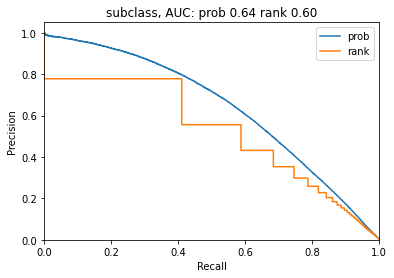

precision@1: 0.7776333333333333
recall@1: 0.41122137808252984
precision@5: 0.2980433333333333
recall@5: 0.7880435740600378


In [21]:
# 3rd model: tencent CNN （summary only）
truth_path = "/pylon5/sez3a3p/yyn1228/data/all_summary_nonstop/test_small.json"
probs_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/CNN_summary_only_all/probs.txt"
label_to_id_maps_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/CNN_summary_only_all/label_to_id_maps.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs_from_json(probs_path)

prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)


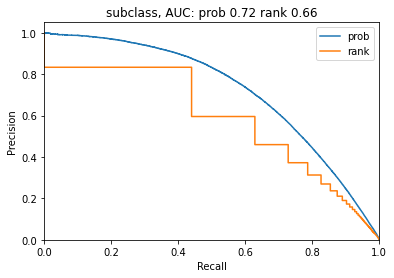

precision@1: 0.8331666666666667
recall@1: 0.44058803828594595
precision@5: 0.3128633333333333
recall@5: 0.827228499409494


In [23]:
# 3rd model: tencent RCNN （summary only）
truth_path = "/pylon5/sez3a3p/yyn1228/data/all_summary_nonstop/test_small.json"
probs_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/RCNN_summary_all/probs.txt"
label_to_id_maps_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/RCNN_summary_all/label_to_id_maps.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs_from_json(probs_path)

prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)


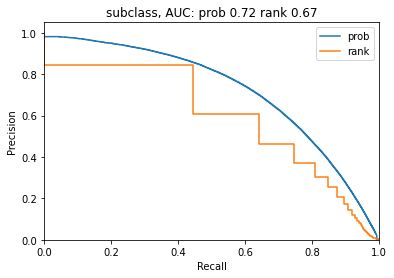

precision@1: 0.8438912903065534
recall@1: 0.4444667358669958
precision@5: 0.30330115005595965
recall@5: 0.8486257337997086


In [17]:
truth_path = "/pylon5/sez3a3p/yyn1228/data/all_summary_nonstop/valid_small.json"
valid_path = "/pylon5/sez3a3p/yyn1228/data/all_summary_fasttext/valid_small.json"

model_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/FastText/summary_all_lr0.2_size300_mincount2/fasttext_model.bin"

subclass_label_to_id_map, probs = get_predicted_probs_from_FASTTEXT(model_path, valid_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

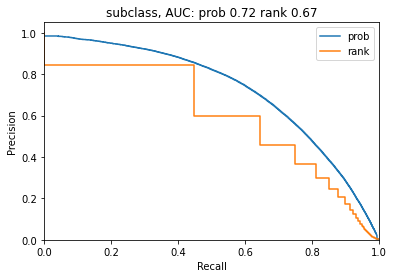

precision@1: 0.8419133490237677
recall@1: 0.4476917382030988
precision@5: 0.2969532612004317
recall@5: 0.8512012832490173


In [18]:
truth_path = "/pylon5/sez3a3p/yyn1228/data/all_summary_nonstop/test_small.json"
valid_path = "/pylon5/sez3a3p/yyn1228/data/all_summary_fasttext/test_small.json"

model_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/FastText/summary_all_lr0.2_size300_mincount2/fasttext_model.bin"

subclass_label_to_id_map, probs = get_predicted_probs_from_FASTTEXT(model_path, valid_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

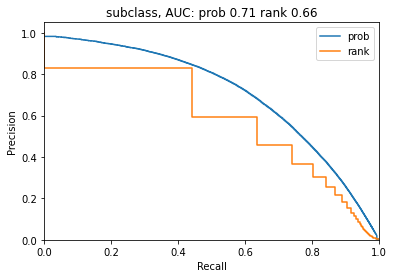

precision@1: 0.8300455486542443
recall@1: 0.44168091519627717
precision@5: 0.3046574521147333
recall@5: 0.8419470836050836


In [17]:
truth_path = "/pylon5/sez3a3p/yyn1228/data/all_summary_nonstop/test_small.json"
valid_path = "/pylon5/sez3a3p/yyn1228/data/all_summary_fasttext/test_small.json"

model_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/FastText/summary_all_lr0.2/all_model_lr0.2.bin"

subclass_label_to_id_map, probs = get_predicted_probs_from_FASTTEXT(model_path, valid_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

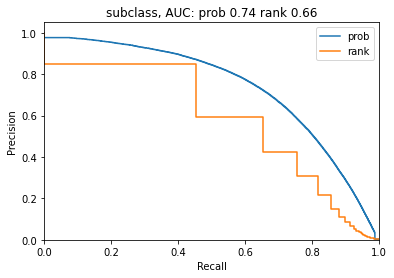

precision@1: 0.8505302165533443
recall@1: 0.45312086866087325
precision@5: 0.21571426351460848
recall@5: 0.8564100756200314


In [17]:
truth_path = "/pylon5/sez3a3p/yyn1228/data/all_summary_nonstop/test_small.json"
valid_path = "/pylon5/sez3a3p/yyn1228/data/all_summary_fasttext/test_small.json"

model_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/FastText/summary_all_subclass/fasttext_model.bin"

subclass_label_to_id_map, probs = get_predicted_probs_from_FASTTEXT(model_path, valid_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

Finished 0 line
Finished 1000 line
Finished 2000 line
Finished 3000 line
Finished 4000 line
Finished 5000 line
Finished 6000 line
Finished 7000 line
Finished 8000 line
Finished 9000 line
Finished 10000 line
Finished 11000 line
Finished 12000 line
Finished 13000 line
Finished 14000 line
Finished 15000 line
Finished 16000 line
Finished 17000 line
Finished 18000 line
Finished 19000 line
Finished 20000 line
Finished 21000 line
Finished 22000 line
Finished 23000 line
Finished 24000 line
Finished 25000 line
Finished 26000 line
Finished 27000 line
Finished 28000 line
Finished 29000 line
Finished 30000 line
Finished 31000 line
Finished 32000 line
Finished 33000 line
Finished 34000 line
Finished 35000 line
Finished 36000 line
Finished 37000 line
Finished 38000 line
Finished 39000 line
Finished 40000 line
Finished 41000 line
Finished 42000 line
Finished 43000 line
Finished 44000 line
Finished 45000 line
Finished 46000 line
Finished 47000 line
Finished 48000 line
Finished 49000 line
Finished 5000

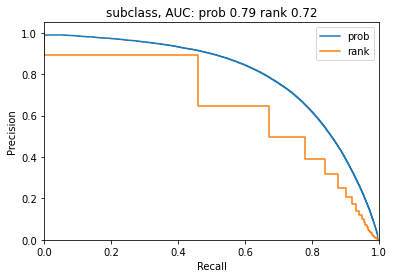

precision@1: 0.8916898700609918
recall@1: 0.45857163557017805
precision@5: 0.31645989946040676
recall@5: 0.8772960118646813


In [22]:
truth_path = "/pylon5/sez3a3p/yyn1228/data/all_summary_nonstop/test_small.json"
valid_path = "/pylon5/sez3a3p/yyn1228/data/all_summary_fasttext/test_small.json"

model_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/FastText/summary_all_lr0.2_size300/fasttext_model.bin"

subclass_label_to_id_map, probs = get_predicted_probs_from_FASTTEXT(model_path, valid_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

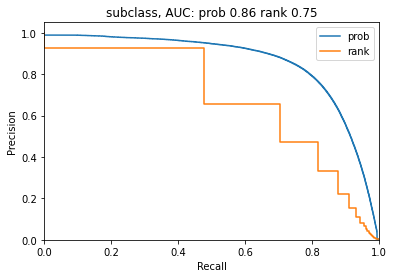

precision@1: 0.9266755965669494
recall@1: 0.4776301321991425
precision@5: 0.22073740238227524
recall@5: 0.9109211322588069


In [18]:
truth_path = "/pylon5/sez3a3p/yyn1228/data/summary_only/test.json"
valid_path = "/pylon5/sez3a3p/yyn1228/data/summary_only_fasttext/test.json"

model_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/FastText/summary_all_subclass_mincount5/fasttext_model.bin"

subclass_label_to_id_map, probs = get_predicted_probs_from_FASTTEXT(model_path, valid_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

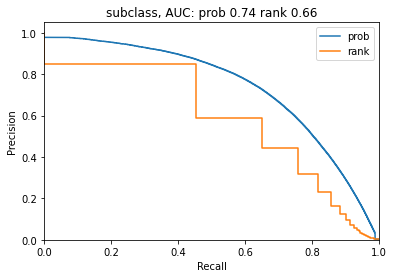

precision@1: 0.8508462798431529
recall@1: 0.453244257989459
precision@5: 0.22859164564639395
recall@5: 0.8570182087394899


In [39]:
truth_path = "/pylon5/sez3a3p/yyn1228/data/all_summary_nonstop/test_small.json"
valid_path = "/pylon5/sez3a3p/yyn1228/data/all_summary_fasttext/test_small.json"

model_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/FastText/summary_all_subclass_mincount5/fasttext_model.bin"

subclass_label_to_id_map, probs = get_predicted_probs_from_FASTTEXT(model_path, valid_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

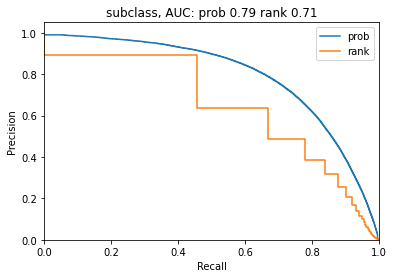

precision@1: 0.891259657150436
recall@1: 0.45821364949754095
precision@5: 0.31589652654636485
recall@5: 0.8776539979373184


In [17]:
truth_path = "/pylon5/sez3a3p/yyn1228/data/summary_only/test.json"
valid_path = "/pylon5/sez3a3p/yyn1228/data/summary_only_fasttext/test.json"

model_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/FastText/summary_all_lr0.2_size300_mincount2/fasttext_model.bin"

subclass_label_to_id_map, probs = get_predicted_probs_from_FASTTEXT(model_path, valid_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

In [30]:
(probs > 0.5).sum(axis=1).mean()

1.46335

In [19]:
def get_average_n(prosb, threshold):
    return (probs > threshold).sum(axis=1).mean()

In [40]:
rank_precisions, rank_recalls, rank_thresholds, rank_auc = rank_result[-1]

In [41]:
prob_precisions, prob_recalls, prob_thresholds, prob_auc = prob_result[-1]

In [42]:
flexible_ns = [get_average_n(probs, threshold) for threshold in prob_thresholds]

In [47]:
flexible_ns

[57.63905,
 56.5621,
 55.50895,
 54.480016666666664,
 53.4584,
 52.46508333333333,
 51.485616666666665,
 50.524433333333334,
 49.5871,
 48.65965,
 47.75468333333333,
 46.86763333333333,
 45.99126666666667,
 45.12736666666667,
 44.29415,
 43.47416666666667,
 42.66795,
 41.876583333333336,
 41.09793333333333,
 40.3389,
 39.5862,
 38.84955,
 38.13106666666667,
 37.42581666666667,
 36.73126666666667,
 36.05591666666667,
 35.386833333333335,
 34.73466666666667,
 34.09336666666667,
 33.46575,
 32.83501666666667,
 32.2352,
 31.635933333333334,
 31.06235,
 30.487066666666667,
 29.93055,
 29.36985,
 28.835283333333333,
 28.30675,
 27.783333333333335,
 27.279833333333332,
 26.788416666666667,
 26.30688333333333,
 25.827366666666666,
 25.35755,
 24.894216666666665,
 24.449533333333335,
 24.008566666666667,
 23.574233333333332,
 23.151483333333335,
 22.727966666666667,
 22.320383333333332,
 21.916783333333335,
 21.514266666666668,
 21.126716666666667,
 20.749183333333335,
 20.382383333333333,
 20.

In [79]:
n = 140
print(prob_recalls[n])
print(flexible_ns[n])
print(prob_thresholds[n])

0.8938058557049937
5.3510333333333335
0.02518884465098381


In [45]:
len(prob_thresholds)

514

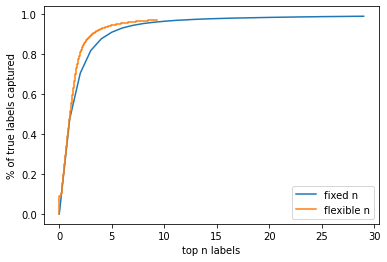

In [23]:
# FOR PRESENTATION
y = rank_recalls[::-1][:30]
x = np.arange(len(y))

plt.figure()
plt.plot(x, y, label = "fixed n")
plt.step(flexible_ns[100:], prob_recalls[1:][100:], where='post', label='flexible n')
plt.xlabel('top n labels')
plt.ylabel('% of true labels captured')
plt.legend(loc='lower right')
plt.show()

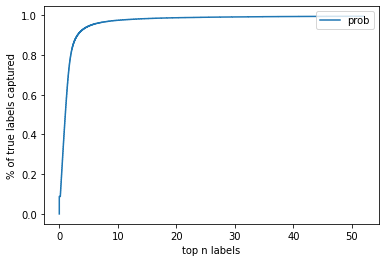

In [29]:
# FOR PRESENTATION
plt.figure()
plt.step(flexible_ns[100:], prob_recalls[1:][100:], where='post', label='prob')

plt.xlabel('top n labels')
plt.ylabel('% of true labels captured')
plt.legend(loc='upper right')
plt.show()

No handles with labels found to put in legend.


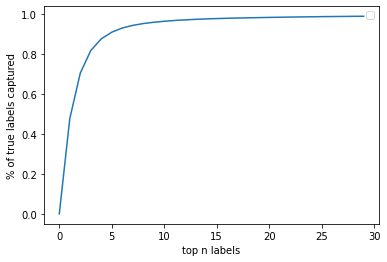

In [37]:
# FOR PRESENTATION
plt.figure()
plt.plot(x, y)

plt.xlabel('top n labels')
plt.ylabel('% of true labels captured')
plt.legend(loc='upper right')
plt.savefig('temp.png', transparent=True)
plt.show()

In [35]:
y[10]

0.9657356187618796

In [28]:
prob_recalls

array([1.        , 0.99463873, 0.9945535 , 0.99446826, 0.99438303,
       0.99428075, 0.99414437, 0.99409323, 0.99399947, 0.99393981,
       0.99385457, 0.9937182 , 0.99362444, 0.99347954, 0.99337726,
       0.99324088, 0.99313008, 0.9930278 , 0.99294256, 0.99281471,
       0.99272095, 0.99257605, 0.99243115, 0.99223511, 0.9921584 ,
       0.99193679, 0.9917578 , 0.99158733, 0.99137424, 0.99127196,
       0.99120377, 0.9910333 , 0.99090545, 0.99076055, 0.99067532,
       0.99047075, 0.99031733, 0.99011277, 0.98999344, 0.98984854,
       0.98963545, 0.98948203, 0.98927746, 0.9890729 , 0.98885981,
       0.98864673, 0.98842512, 0.98829726, 0.98813532, 0.98796485,
       0.98778586, 0.98760686, 0.98739378, 0.98718921, 0.98699317,
       0.98680566, 0.98660109, 0.98640505, 0.98619197, 0.98597888,
       0.98564646, 0.9854419 , 0.98520324, 0.98501573, 0.98478559,
       0.98452136, 0.98418042, 0.9839162 , 0.98371163, 0.98337069,
       0.98298714, 0.98272291, 0.98245016, 0.98226264, 0.98193

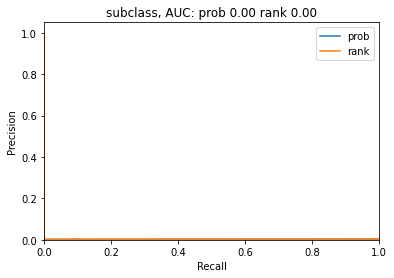

precision@1: 0.0008333333333333334
recall@1: 0.00042617389599652243
precision@5: 0.0021766666666666666
recall@5: 0.005565831081714582


In [57]:
# BERT GOGOGO!
truth_path = "/pylon5/sez3a3p/yyn1228/data/summary_only_nonstop/test.json"
probs_path = "/pylon5/sez3a3p/yyn1228/data/bert_part/predict"
subclass_label_to_id_map, probs = get_predicted_probs_from_BERT(probs_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

In [58]:
probs_BERT = read_pickle("/pylon5/sez3a3p/yyn1228/data/bert_part/predict")

In [69]:
for i in range(200):
    print([label[0] for label in probs_BERT[i][:5]])

['B--B31--B31B', 'E--E04--E04F', 'C--C05--C05G', 'B--B44--B44B', 'C--C07--C07D']
['B--B31--B31B', 'C--C09--C09H', 'B--B44--B44B', 'G--G05--G05G', 'B--B61--B61C']
['B--B31--B31B', 'B--B44--B44B', 'C--C07--C07D', 'E--E04--E04F', 'C--C05--C05G']
['B--B31--B31B', 'E--E04--E04F', 'C--C07--C07D', 'B--B44--B44B', 'C--C05--C05G']
['B--B31--B31B', 'E--E04--E04F', 'C--C07--C07D', 'C--C05--C05G', 'B--B44--B44B']
['B--B31--B31B', 'E--E04--E04F', 'A--A99--A99Z', 'B--B44--B44B', 'C--C09--C09H']
['B--B31--B31B', 'C--C07--C07D', 'B--B44--B44B', 'C--C05--C05G', 'E--E04--E04F']
['B--B31--B31B', 'E--E04--E04F', 'C--C05--C05G', 'C--C07--C07D', 'B--B44--B44B']
['B--B31--B31B', 'F--F04--F04B', 'B--B44--B44B', 'G--G05--G05G', 'C--C07--C07D']
['B--B31--B31B', 'C--C05--C05G', 'E--E04--E04F', 'B--B63--B63G', 'A--A99--A99Z']
['B--B31--B31B', 'C--C07--C07D', 'B--B44--B44B', 'E--E04--E04F', 'C--C05--C05G']
['B--B31--B31B', 'C--C05--C05G', 'E--E04--E04F', 'B--B63--B63G', 'C--C07--C07D']
['B--B31--B31B', 'C--C07--C0

In [55]:
with open("/pylon5/sez3a3p/yyn1228/data/all_summary_nonstop/test.json", 'r') as truth_file:  
    for i, truth in enumerate(truth_file):
        true_labels = json.loads(truth)["doc_label"]
        print(true_labels)
        if i > 20:
            break

['G--G06--G06F']
['G--G06--G06F']
['G--G06--G06F']
['H--H04--H04L', 'G--G06--G06F']
['G--G06--G06F']
['G--G06--G06F']
['G--G07--G07G', 'G--G06--G06Q', 'G--G07--G07F', 'G--G06--G06F']
['G--G11--G11B']
['G--G06--G06F']
['G--G06--G06F']
['G--G06--G06F']
['G--G06--G06F']
['G--G06--G06F']
['G--G06--G06F']
['G--G11--G11B']
['G--G11--G11B']
['G--G11--G11B']
['G--G11--G11B']
['G--G11--G11B']
['G--G11--G11B']
['G--G11--G11B']
['H--H01--H01Q']


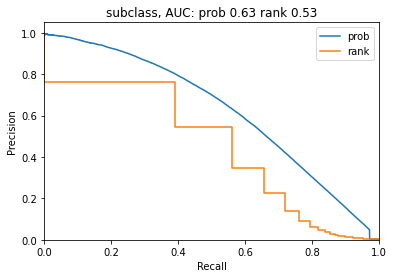

precision@1: 0.7634030497458545
recall@1: 0.390443476556174
precision@5: 0.13798291084105105
recall@5: 0.7614363764990667


In [18]:
# 2nd model HFT-CNN (summary all data)
truth_path = "/pylon5/sez3a3p/yyn1228/data/summary_only_nonstop/test.json"
probs_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/HFT-CNN/CNN/RESULT/probability_3rd.csv"
subclass_label_to_id_map, probs = get_predicted_probs_from_json_with_header(probs_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

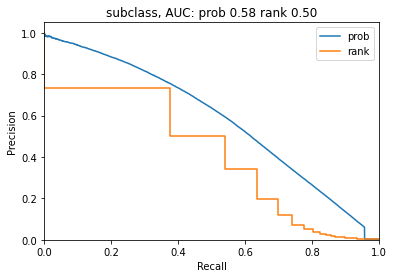

precision@1: 0.7326811871948272
recall@1: 0.3747432302276621
precision@5: 0.11887257244763916
recall@5: 0.7419943233637053


In [18]:
# 2nd model HFT-CNN (summary all data)
truth_path = "/pylon5/sez3a3p/yyn1228/data/summary_only_nonstop/test.json"
probs_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/HFT-CNN/CNN/RESULT/test_probability_3rd.csv"
subclass_label_to_id_map, probs = get_predicted_probs_from_json_with_header(probs_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

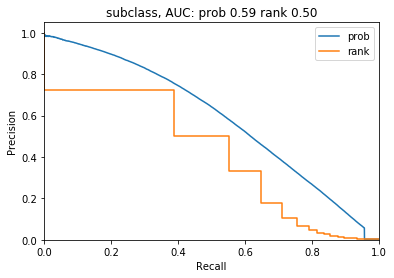

precision@1: 0.72297155426686
recall@1: 0.3869552187687302


In [28]:
# 2nd model HFT-CNN (summary all data)
probs_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/HFT-CNN/CNN-subclass-word100-unit512/RESULT/probability_3rd.csv"
subclass_label_to_id_map, probs = get_predicted_probs_from_json_with_header(probs_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

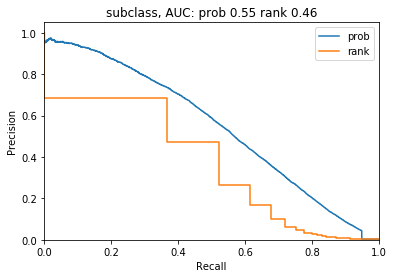

precision@1: 0.6839316068393161
recall@1: 0.3660690393363661


In [23]:
# 2nd model HFT-CNN (summary all data)
probs_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/HFT-CNN/CNN-subclass-word50/RESULT/probability_3rd.csv"
subclass_label_to_id_map, probs = get_predicted_probs_from_json_with_header(probs_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

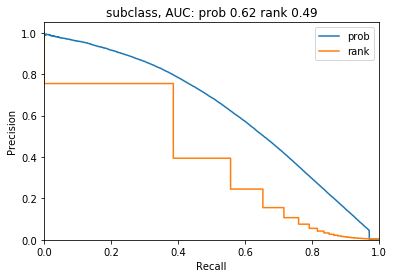

precision@1: 0.7546283181416741
recall@1: 0.3859942210819703
precision@5: 0.10692926166435104
recall@5: 0.7602857069798761


In [41]:
# 2nd model HFT-CNN (summary 2000 non-stop)
probs_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/HFT-CNN-qd/CNN-FT-summary-2000/RESULT/probability_3rd.csv"
subclass_label_to_id_map, probs = get_predicted_probs_from_json_with_header(probs_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

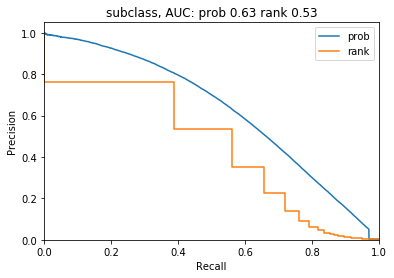

precision@1: 0.7615437169852194
recall@1: 0.3895314644187414
precision@5: 0.14107259191792693
recall@5: 0.7604306061045149


In [42]:
# 2nd model HFT-CNN (summary 300 non-stop)
probs_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/HFT-CNN-qd/CNN-summarynonstop-300/RESULT/probability_3rd.csv"
subclass_label_to_id_map, probs = get_predicted_probs_from_json_with_header(probs_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

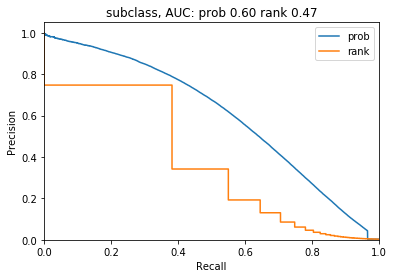

precision@1: 0.7470921513081153
recall@1: 0.3821330855842418
precision@5: 0.08569552358807682
recall@5: 0.7485829717958116


In [43]:
# 2nd model HFT-CNN (summary 300 non-stop finetuning)
probs_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/HFT-CNN-qd/CNN-FT-summarynonstop-300/RESULT/probability_3rd.csv"
subclass_label_to_id_map, probs = get_predicted_probs_from_json_with_header(probs_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

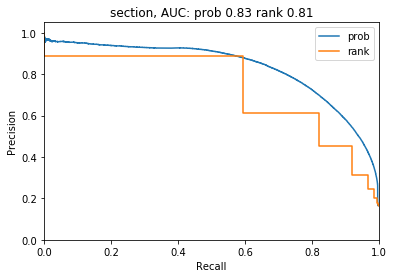

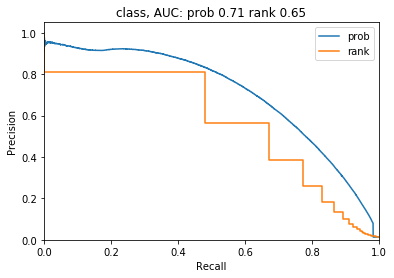

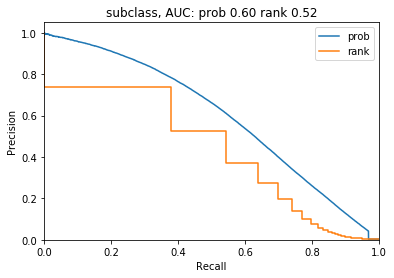

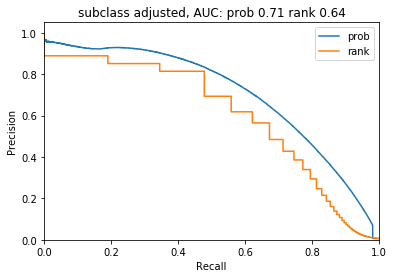

In [472]:
# 2nd model HFT-CNN (summary 150)
probs_path = "../../../../CNN-summary-150.csv"
subclass_label_to_id_map, probs = get_predicted_probs_from_json_with_header(probs_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

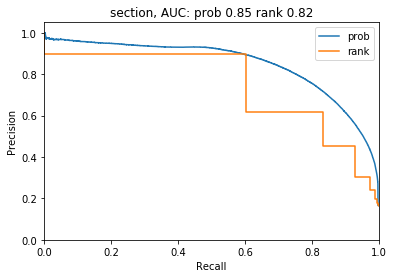

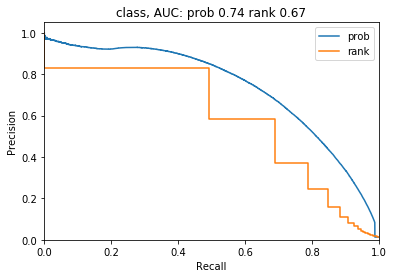

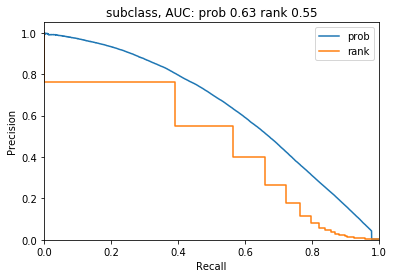

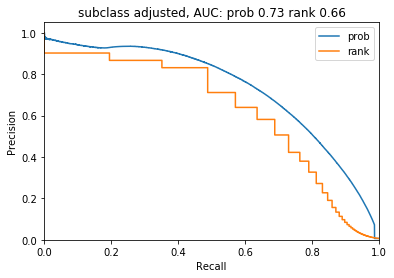

In [473]:
# 2nd model HFT-CNN (summary 1000)
probs_path = "../../../../CNN-summary-1000.csv"
subclass_label_to_id_map, probs = get_predicted_probs_from_json_with_header(probs_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

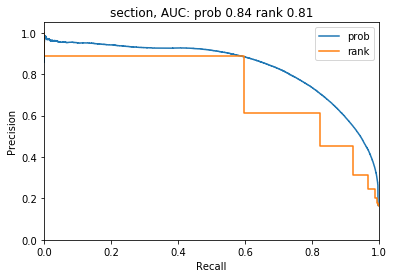

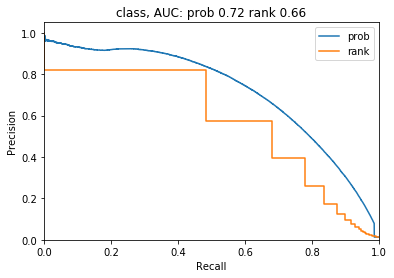

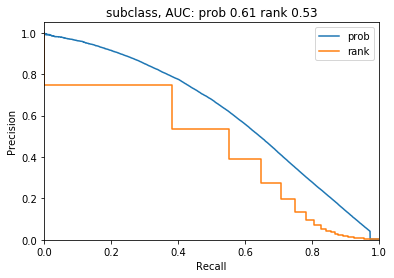

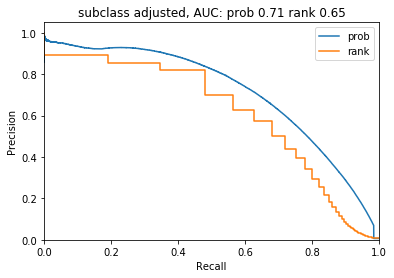

In [474]:
# 2nd model HFT-CNN (description)
probs_path = "../../../../CNN-desc-300.csv"
subclass_label_to_id_map, probs = get_predicted_probs_from_json_with_header(probs_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

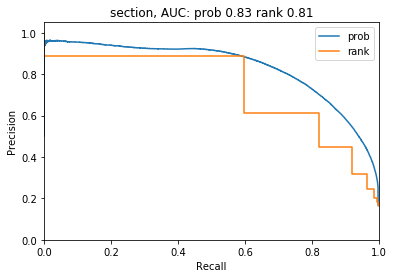

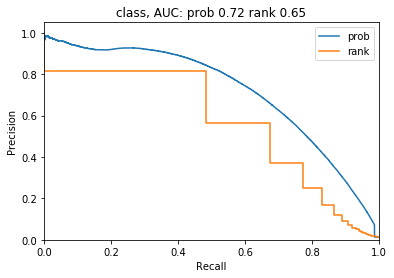

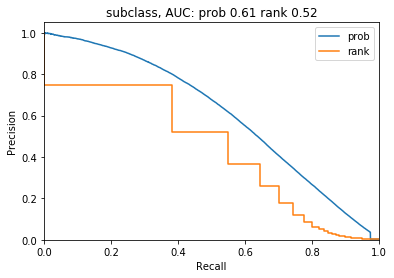

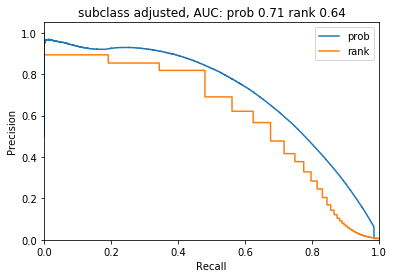

In [475]:
# 2nd model HFT-CNN (title abstract claim)
probs_path = "../../../../probability_3rd.txt"
subclass_label_to_id_map, probs = get_predicted_probs_from_json_with_header(probs_path)
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

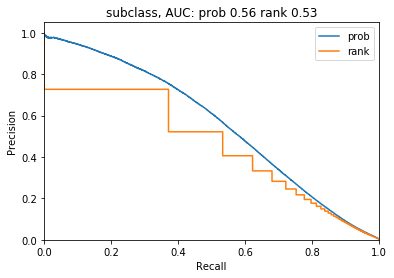

precision@1: 0.7266833333333333
recall@1: 0.3716321607868875
precision@5: 0.2823857253809154
recall@5: 0.7220749554648279


In [34]:
# 3rd model: tencent CNN （summary only）
truth_path = "/pylon5/sez3a3p/yyn1228/data/summary_only/test.json"
probs_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/CNN_summary_only/probs.txt"
label_to_id_maps_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/CNN_summary_only/label_to_id_maps.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs_from_json(probs_path)

prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

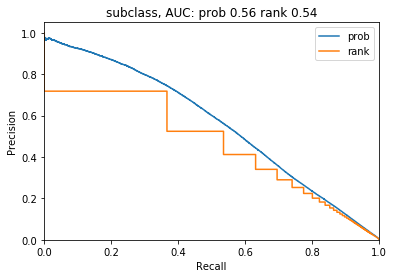

precision@1: 0.7177166666666667
recall@1: 0.3670465296659649
precision@5: 0.2897266666666667
recall@5: 0.7408436538445147


In [35]:
# 3rd model: tencent fasttext (summary 1000)

probs_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/fasttext_summary/probs.txt"
label_to_id_maps_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/fasttext_summary/label_to_id_maps.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs_from_json(probs_path)

prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

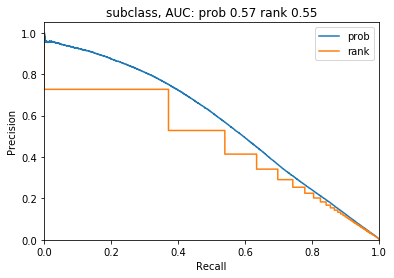

precision@1: 0.72665
recall@1: 0.3716151138310476
precision@5: 0.2905433333333333
recall@5: 0.7429319059348977


In [36]:
# 3rd model: tencent fasttext (summary 1000 nonstop)

probs_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/fasttext_summary_2000/probs.txt"
label_to_id_maps_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/fasttext_summary_2000/label_to_id_maps.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs_from_json(probs_path)

prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

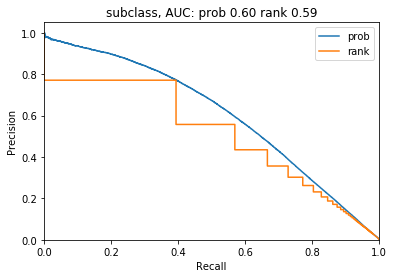

precision@1: 0.7707038216029732
recall@1: 0.39415118945134375
precision@5: 0.30217666666666665
recall@5: 0.7726788438754549


In [37]:
# 3rd model: tencent fasttext (fasttext_summary_pretrain)

probs_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/fasttext_summary_pretrain/probs.txt"
label_to_id_maps_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/fasttext_summary_pretrain/label_to_id_maps.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs_from_json(probs_path)

prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

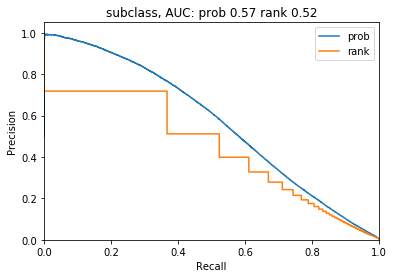

precision@1: 0.7181666666666666
recall@1: 0.36727666356980304
precision@5: 0.27831
recall@5: 0.7116507419687529


In [38]:
# 3rd model: tencent RCNN (summary 1024)

probs_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/RCNN_summary_1000/probs.txt"
label_to_id_maps_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/RCNN_summary_1000/label_to_id_maps.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs_from_json(probs_path)

prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

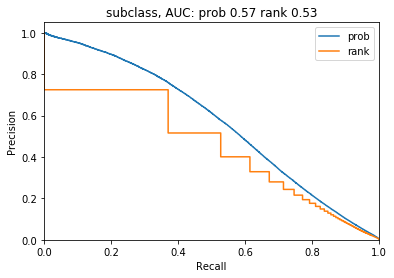

precision@1: 0.7246166666666667
recall@1: 0.37057524952481613
precision@5: 0.27962333333333333
recall@5: 0.7150089922692056


In [39]:
# 3rd model: tencent RCNN (summary 512)

probs_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/RCNN_summary/probs.txt"
label_to_id_maps_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/RCNN_summary/label_to_id_maps.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs_from_json(probs_path)

prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

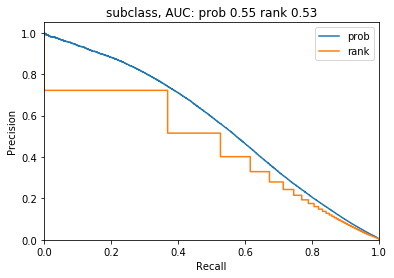

precision@1: 0.7217
recall@1: 0.3690836408888283
precision@5: 0.27935666666666664
recall@5: 0.7143271140356111


In [40]:
# 3rd model: tencent RNN (summary)

probs_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/RNN_summary/probs.txt"
label_to_id_maps_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/RNN_summary/label_to_id_maps.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs_from_json(probs_path)

prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

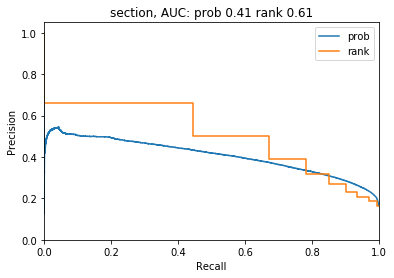

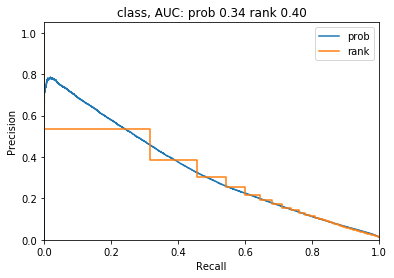

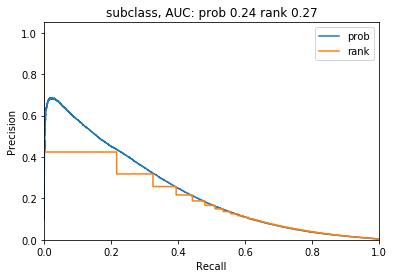

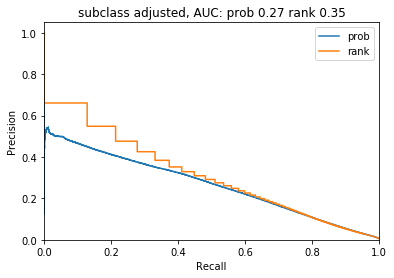

In [482]:
# 3rd model: tencent CNN (summary pretrain)

probs_path = "../../../../probs_pretrain.txt"
label_to_id_maps_path = "../../../../label_to_id_maps_pretrain.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs_from_json(probs_path)

prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

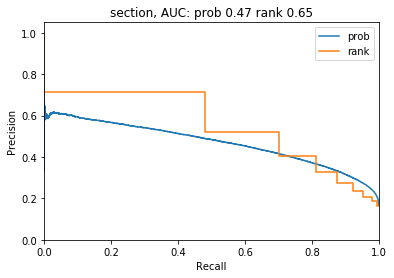

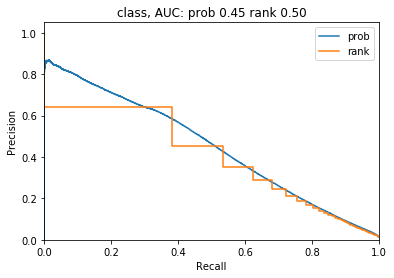

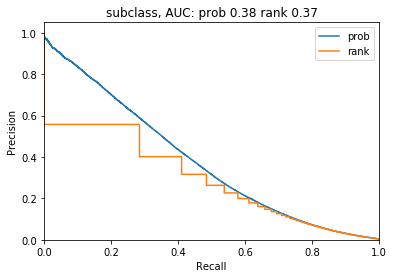

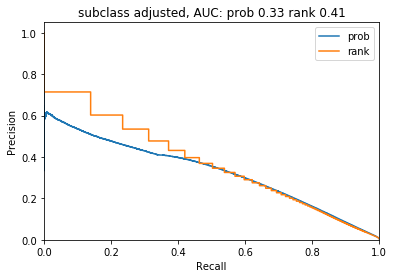

In [476]:
# 3rd model: tencent CNN (title abstract claim)

probs_path = "../../../../probs_claim.txt"
label_to_id_maps_path = "../../../../label_to_id_maps_claim.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs_from_json(probs_path)

prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

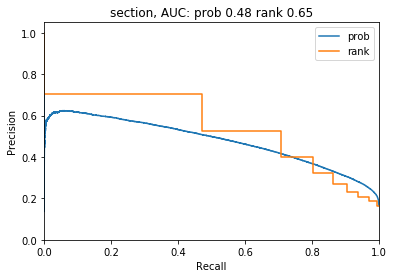

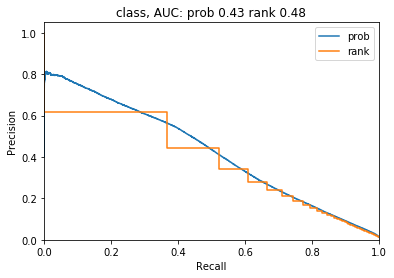

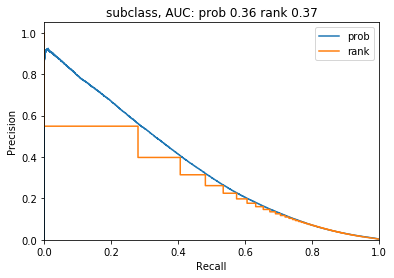

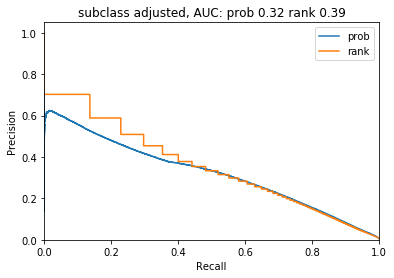

In [21]:
# 3rd model: tencent CNN (summary only nonstop)

probs_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/CNN_summary_only_nonstop/probs.txt"
label_to_id_maps_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/CNN_summary_only_nonstop/label_to_id_maps.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs_from_json(probs_path)

prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

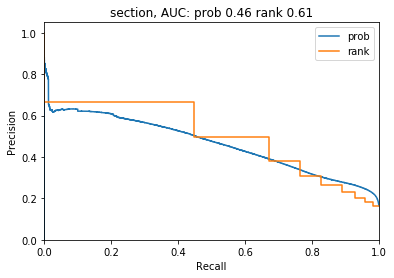

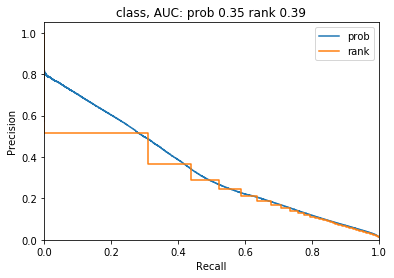

In [ ]:
# 3rd model: tencent CNN (summary only nonstop all data)
truth_path = "/pylon5/sez3a3p/yyn1228/data/all_summary_nonstop/test.json"
probs_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/CNN_summary_only_nonstop_all/probs.txt"
label_to_id_maps_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output/CNN_summary_only_nonstop_all/label_to_id_maps.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs_from_json(probs_path)

prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

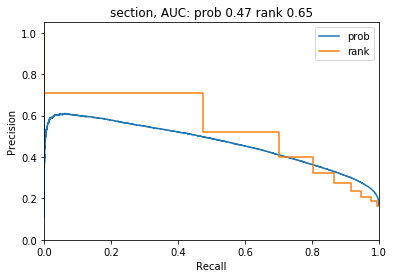

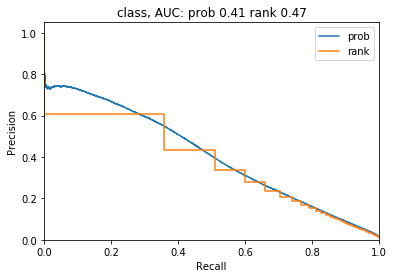

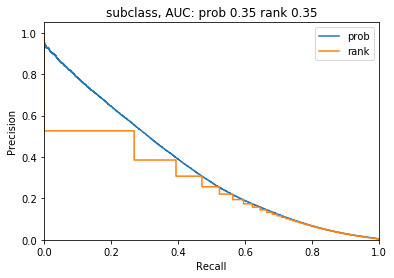

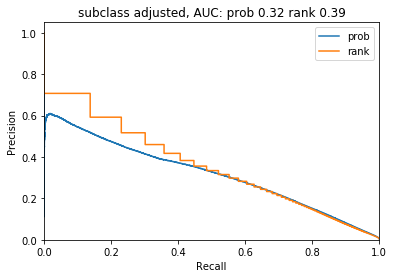

In [477]:
# 3rd model: tencent CNN (summary only)

probs_path = "../../../../probs_sum.txt"
label_to_id_maps_path = "../../../../label_to_id_maps_sum.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs_from_json(probs_path)

prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

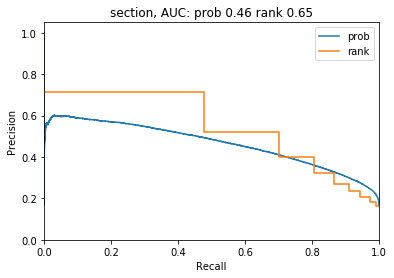

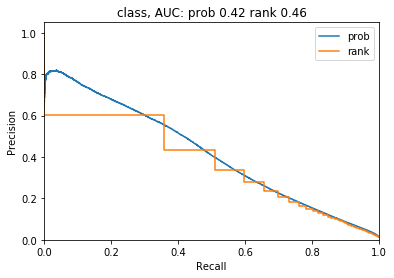

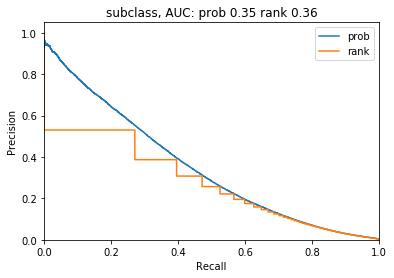

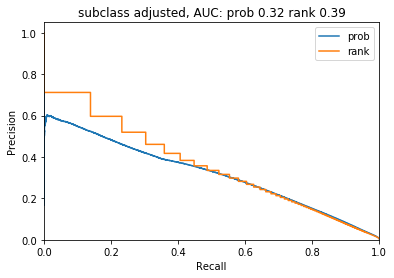

In [478]:
# 3rd model: tencent CNN (desc only)

probs_path = "../../../../probs_desc.txt"
label_to_id_maps_path = "../../../../label_to_id_maps_desc.pkl"
label_to_id_maps = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = label_to_id_maps[0]

truth_array = get_truth_array(truth_path, subclass_label_to_id_map)
probs = get_predicted_probs_from_json(probs_path)

prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

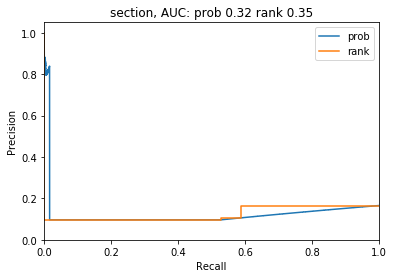

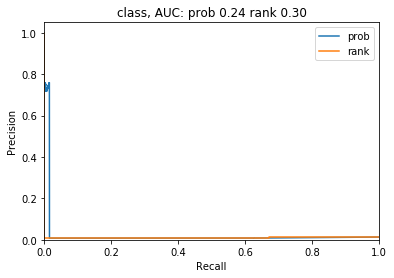

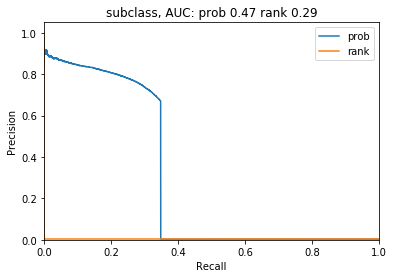

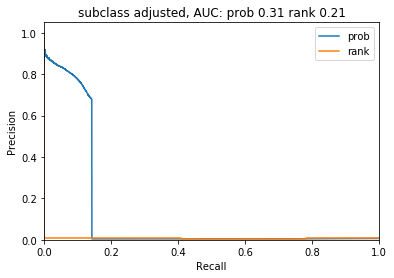

In [479]:
# 1st model: sklearn approach (title abstract claim)

probs_path = "../../../../test_dump_y_pred_parallel_RM"
label_to_id_maps_path = "../../../../mlb_classes"
label_to_id_list = read_pickle(label_to_id_maps_path)
subclass_indices, subclass_label_to_id_map = get_level_indices(list_to_dict(label_to_id_list), 2)
    
probs = np.array(read_pickle(probs_path))[:, subclass_indices]
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

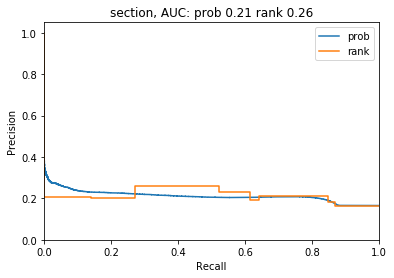

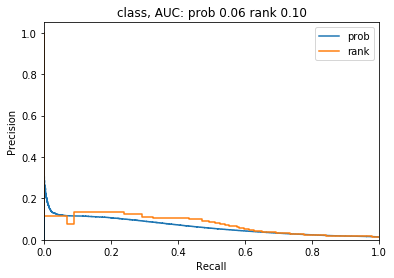

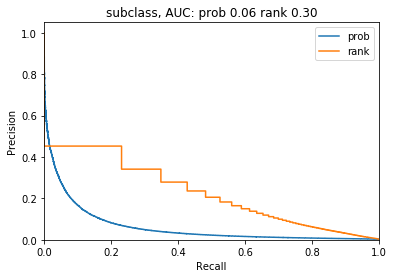

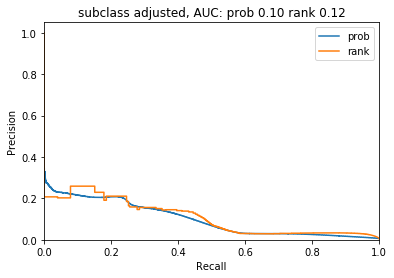

In [480]:
# 4th model: bottom-up approach (title abstract claim)

probs_path = "../../../../result_cos.save"
label_to_id_maps_path = "../../../../node_labels_cos.save"
label_to_id_list = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = list_to_dict(label_to_id_list)
    
probs = np.array(read_pickle(probs_path))
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

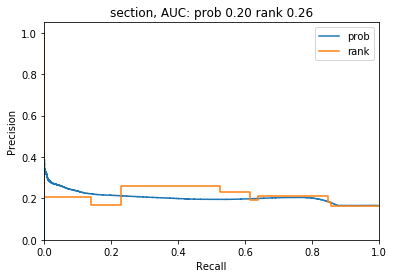

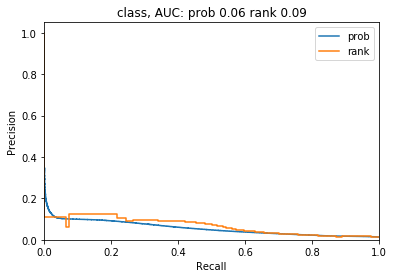

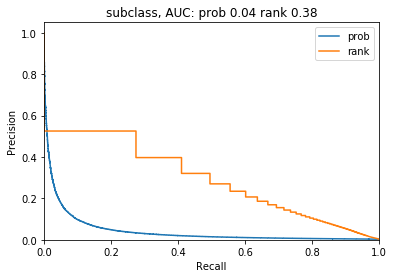

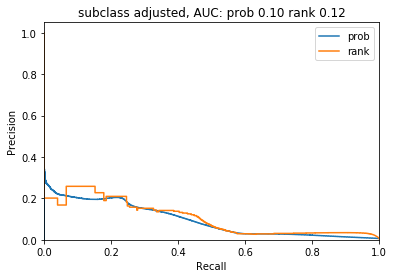

In [481]:
# 4th model: bottom-up approach (summary only)

probs_path = "../../../../result_cos_summary_only"
label_to_id_maps_path = "../../../../node_labels_cos_summary_only"
label_to_id_list = read_pickle(label_to_id_maps_path)
subclass_label_to_id_map = dict()
for i, label in enumerate(label_to_id_list):
    subclass_label_to_id_map[label] = i
    
probs = np.array(read_pickle(probs_path))
prob_result, rank_result = get_pr_curves(truth_path, subclass_label_to_id_map, probs)

In [2]:
def load_text_stats(input_json_path):
    lens = []
    with open(input_json_path, 'r') as f:
        for line in f:
            lens.append(len(json.loads(line)["doc_token"]))
    ds = pd.Series(lens)
    return ds.describe()

In [7]:
load_text_stats("/pylon5/sez3a3p/yyn1228/data/summary_only/test.json")

count     60000.000000
mean       1562.199400
std        1890.177628
min           0.000000
25%         703.000000
50%        1132.500000
75%        1817.000000
max      156368.000000
dtype: float64

In [8]:
load_text_stats("/pylon5/sez3a3p/yyn1228/data/summary_only_nonstop/test.json")

count    60000.000000
mean       921.407350
std       1173.798464
min          0.000000
25%        411.000000
50%        659.000000
75%       1059.000000
max      95283.000000
dtype: float64

In [10]:
load_text_stats("/pylon5/sez3a3p/yyn1228/data/processed_data/test.json")

count    60000.000000
mean      1120.005750
std        792.703603
min         40.000000
25%        627.000000
50%        950.000000
75%       1385.000000
max      25214.000000
dtype: float64

In [11]:
load_text_stats("/pylon5/sez3a3p/yyn1228/data/title_abs_claim_nonstop/test.json")

count    60000.000000
mean       697.577467
std        513.399636
min         25.000000
25%        387.000000
50%        587.000000
75%        858.000000
max      17638.000000
dtype: float64

In [12]:
load_text_stats("/pylon5/sez3a3p/yyn1228/data/desc_only/test.json")

count     60000.000000
mean       6852.938283
std        7855.357073
min         273.000000
25%        3018.000000
50%        4828.000000
75%        7955.000000
max      252528.000000
dtype: float64

In [13]:
load_text_stats("/pylon5/sez3a3p/yyn1228/data/desc_only_nonstop/test.json")

count     60000.000000
mean       4052.066350
std        4910.639534
min         141.000000
25%        1721.000000
50%        2792.000000
75%        4648.250000
max      157187.000000
dtype: float64

In [25]:
def load_text_stats_2(input_json_path, text_field):
    lens = []
    with open(input_json_path, 'r') as f:
        for i, line in enumerate(f):
            lens.append(len(json.loads(line)[text_field]))
            if i >= 10000:
                break
    ds = pd.Series(lens)
    return ds.describe()

In [26]:
load_text_stats_2("/pylon5/sez3a3p/yyn1228/data/all_data/test.json", "title")

count    10001.000000
mean         7.406759
std          4.343723
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         40.000000
dtype: float64

In [27]:
load_text_stats_2("/pylon5/sez3a3p/yyn1228/data/all_data/test.json", "abstraction")

count    10001.000000
mean       112.228877
std         48.904034
min          6.000000
25%         77.000000
50%        108.000000
75%        143.000000
max        378.000000
dtype: float64

In [29]:
load_text_stats_2("/pylon5/sez3a3p/yyn1228/data/all_data/test.json", "claims")

count    10001.000000
mean       878.855714
std        707.594776
min          3.000000
25%        426.000000
50%        711.000000
75%       1115.000000
max       9691.000000
dtype: float64

In [30]:
def get_row_count(file_path):
    count = 0
    with open(file_path, 'r') as f:
        for line in f:
            count += 1
    return count

In [33]:
get_row_count("/pylon5/sez3a3p/yyn1228/data/processed_data/train.json")

260000